# Solución Tarea 4

#### Estudiantes:
- Nicolás Prieto Escobar
- Pablo A. Saldarriaga Aristizabal

### Nota: para que los plots se generen y se vean bien, es necesario ejecutar todo el notebook y tener la carpeta  de github clonada en el PC local. Descargar solo el html NO generará bien los plots, ya que se usan otros html que están en un subdirectorio de donde está este notebook.

### Problema:

Se cuenta con información georeferenciada de accidentes que han ocurrido en diferentes barrios en la ciudad de Medellín durante el año 2017. 

En este ejemplo, se usarán solo los datos de los accidentes que estén en los barrios de la comuna 14, El Poblado. Lo que se pretende es mostrar las ventajas que se tiene al usar una técnica de clusters basados en densidad (DBSCAN) para hallar los clusters de accidentalidad más importante de esa comuna.

Se analizará el resultado final obtenido por esta técnica y se hará un análisis de sensbilidad de algunso de sus parámetros (tipo de distancia usada, radio de las vecindades, etc).


In [1]:
%matplotlib notebook

### Limpieza y preparacion de datos

In [2]:
### Lectura de datos

### crear carpeta resultados
import os
if not os.path.exists('pruebas/'):
    os.makedirs('pruebas')

### Leer datos
import pandas as pd
datos = pd.read_csv('data/proc_accidentes_2017.csv')


### Dejar solo accidentes del Poblado
lista_poblado = """
ElGuamal
BarrioColombia
VillaCarlota
Castropol
Lalinde
LasLomasNo1
LasLomasNo2
AltosdelPoblado
ElTesoro
LosNaranjos
LosBalsosNo1
SanLucas
ElDiamanteNo2
ElCastillo
LosBalsosNo2
Alejandria
LaFlorida
ElPoblado
Manila
Astorga
PatioBonito
LaAguacatala
SantaMariadeLosÁngeles
"""
lista_poblado_l = lista_poblado.split('\n')

In [3]:
## Dejar solo barrios del poblado
datos_pob = datos[datos['BARRIO'].isin(lista_poblado_l)]

### Eliminar un dato outlier raro, cuyas coordenadas quedan en san antonio de prado
datos_pob = datos_pob[datos_pob['Lon']>-75.62] 


### Preparacion inicial de datos
lat = datos_pob['Lat']
lon = datos_pob['Lon']

import numpy as np
import random
random.seed(42)

In [4]:
### Para que quede mejor el plot, le sumo un random pequeno
### Esto lo hago porque en la base de datos hay varias observaciones con
### exactamente la misma coordenada, esto probablemente sea una imprecision
### al etiquetar la ubicaciion del accidente, y en el mapa quedaba un punto
### encima del otro y se notaba que ahi habia varios accidentes
lats=[]
lons=[]
for i in range(len(lat)):
    lats.append(0.0005*random.random())
    lons.append(0.0005*random.random())

lat = lat + lats
lon = lon + lons

datos_pob['Lat'] = lat
datos_pob['Lon'] = lon



###### Funcion auxiliar para hacer los plots:


In [5]:
############ Plotting
### Ploteo en mapa los clusters
import gmplot 
def plotmap(etiqs, nombre):
    
    ## Creo el plot
    gmap3 = gmplot.GoogleMapPlotter(lat.mean(), lon.mean(), 14) 
    
    colors_list = [ '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#ffffff','#e6194b', '#000000', '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
    
    for i in range(max(etiqs)+1):
        latitude_list = np.array(lat)[np.where(np.array(etiqs)==i)]
        longitude_list = np.array(lon)[np.where(np.array(etiqs)==i)]
            
        # Pintar puntos de cada cluster, como circulos de cada color
        gmap3.scatter( latitude_list, longitude_list, colors_list[i], 
                                      size = 8, marker = False ) 
          
    
        
    ### Pinto los que quedaron como outliers, son circulos grises
    latitude_list = np.array(lat)[np.where(np.array(etiqs)==-1)]
    longitude_list = np.array(lon)[np.where(np.array(etiqs)==-1)]
    gmap3.scatter( latitude_list, longitude_list, 'gray', 
                                  size = 8, marker = False )     
        
    
    ### Guardo el plot
    gmap3.draw( "pruebas/"+nombre+".html" ) 
    
    return None

### Clustering final obtenido con dbscan

Primero, mostraremos el resultado final obtenido al hacer clustering con dbscan, el cual obtuvimos luego de evaluar distintos metodos, hiperparametros y distancias en el modelo.
Mostramos aqui este resultado para no tener que mostrar de nuevo este mapa en cada ocasion futura. Sin embargo, todos estos parametros obtenidos fueron el resultado de varias evaluaciones (luego de mostrar el mapa con el resultado final del clustering, mostraremos el analisis de sensibilidad).

In [6]:

############ Clustering DBSCAN

### Usar dbscan para clustering
from sklearn.cluster import DBSCAN


kms_per_radian = 6371.0088  ### Para poder usar km se usa esto
distancia_en_km = 0.18   ### El radio de cada bola del metodo, en este caso es de 0.18km o 180m

epsilon = distancia_en_km / kms_per_radian  ### Esto es auxiliar, para poder usar km con las coordenadas

min_points = 20  ### Elegimos que para que un punto sea considerado denso, debe haber al menos 20 puntos en su bola
clu = DBSCAN(eps=epsilon, min_samples=min_points, metric='manhattan')  ## Usar dbscan, con metrica L1 o manhattan
clu.fit(np.radians(datos_pob[['Lat','Lon']].values))

etiqs = list(clu.labels_) ### Clusters encontrados

In [7]:
### Plotear resultado clusters dbscan
plotmap(etiqs, 'map_final')


### Mostrar aqui el html
from IPython.display import IFrame
IFrame(src='pruebas/map_final.html', width=700, height=600)

Vemos que los resultados obtenidos con dbscan son satisfactorios: se logran encontrar muchas de las agrupaciones de accidentalidad en los sitios donde el sentido común nos dice que se esperaba encontrarlas (glorieta de la aguacatala, puente Gilberto Echeverri Mejía, etc), y además notamos que el uso del clustering por densidad permite armar clusters que pueden tener distintas formas y tamaños (notar que algunas secciones como todo el parque Lleras y la 10 quedan en el mismo cluster, a pesar de ser zonas alargadas, mientras que también hay zonas pequeñas como la glorieta de la agucatala que también terminan formando un cluster).

Ademas, notar que tambien el método logra detectar que ocurren muchos accidentes en la ciudad que ocurren por simple casualidad pero no representan puntos de gran interés: estos son los puntos grises en el plot. Representarían los outliers de este modelo, son accidentes que ocurrieron pero no se asociaron exactamente a las zonas con dinámicas más comunes de accidentalidad en la zona. Notar que estos puntos están regados a través de todo el mapa, tal como se esperaba ver.

### Análisis de sensibilidad 

Habiendo mostrado ya el resultado final obtenido, mostraremos entonces en esta seccion el analisis de sensibilidad relacionado. Lo que haremos ahora es entonces mostrar como diversas partes del modelo (distancia usada, hiperaparametros, etc) afectaban el resultado y asi sustentaremos porque nos quedamos con el resultado final mostrado anteriormente.

##### Metodo de clustering: ventaja de dbscan sobre kmeans

Se muestra como hubieran quedado los clusters al usar kmeans tradicional, para comparar su rendimiento con el cluster basado en densidad de dbscan.

In [8]:
### Clustering con Kmeans
from sklearn.cluster import KMeans

n_clusters=19 ## Este es el numero de clusters que hallo dbscan

clu_k = KMeans(n_clusters=n_clusters, random_state=1)  ## Usar kmeans
clu_k.fit(np.radians(datos_pob[['Lat','Lon']].values))

etiqs_kmeans = list(clu_k.labels_) ### Clusters encontrados con kmeans


In [9]:
#### Plot con Kmeans
plotmap(etiqs_kmeans, 'map_kmeans')


### Mostrar aqui el html
from IPython.display import IFrame
IFrame(src='pruebas/map_kmeans.html', width=700, height=600)

Podemos ver que kmeans utiliza una forma muy similar en todos sus clusters: un circulo con un centroide en alguna de las zonas. Esto no representa bien los datos ya que muchas de las zonas aqui analizadas tienen distintas formas y tamaños no es muy adecuado analizarlas con el kmeans. El ejemplo más claro de esto está en el Parque Lleras y la calle 10 (clusters que están debajo de la palabra "Lalinde"): toda esa región representa una zona muy frecuenta de la ciudad atravesad por la misma calle y toda esa calle tiene una dinámica muy similar (muchos accidentes por ser tan transitada), por esta razón es mucho más lógico agrupar todo el parque lleras y la calle 10 en un mismo cluster como lo hace dbscan que hacerlo como lo hace aquí kmeans. KMeans lo divide en dos clusters cuando no debería ser así, esto ocurre porque KMeans no es tan bueno para identificar clusters de distintas formas y tamaños, algo que sí hace mejor DBSCAN.

Otro detalle importante son los outliers: hay accidentes que ocurrieron en regiones de muy baja accidentalidad que en realidad son más producto de la casualidad que de las condiciones de esa zona. DBSCAN hacía bien esta tarea al ser capaz de poner estos accidentes casuales como outliers que no representan en realidad clusters de accidentalida (no están en zonas densas). Por otro lado, KMeans siempre asignaba todos los puntos a todos los clusters, lo que no permite usar este método para detectar cuáles accidentes de verdad ocurren en los puntos de alta accidentalidad de la zona y cuales no, dándole entonces de nuevo la ventaja a DBSCAN.

#### Ventajas de la distancia de manhattan sobre otros tipos de distancias.

En el método final, se usa la distancia de Manhattan en el DBSCAN. Aquí se analizan los resultados obtenidos por otro par de métricas para sustentar la ventaja de la métrica de manhattan sobre las demás en este caso.

In [10]:
############ Clustering DBSCAN con distancia euclideana (L2)

### Usar dbscan para clustering
from sklearn.cluster import DBSCAN


kms_per_radian = 6371.0088  ### Para poder usar km se usa esto
distancia_en_km = 0.18   ### El radio de cada bola del metodo, en este caso es de 0.18km o 180m

epsilon = distancia_en_km / kms_per_radian  ### Esto es auxiliar, para poder usar km con las coordenadas

min_points = 20  ### Elegimos que para que un punto sea considerado denso, debe haber al menos 20 puntos en su bola
clu_l2 = DBSCAN(eps=epsilon, min_samples=min_points, metric='euclidean')  ## Usar dbscan, con metrica L2 o euclideana
clu_l2.fit(np.radians(datos_pob[['Lat','Lon']].values))

etiqs_l2 = list(clu_l2.labels_) ### Clusters encontrados

In [11]:
### Plotear resultado clusters dbscan
plotmap(etiqs_l2, 'map_euclidean')


### Mostrar aqui el html
from IPython.display import IFrame
IFrame(src='pruebas/map_euclidean.html', width=700, height=600)

Vemos que al usar la distancia euclideana, termina juntando casi todos los puntos en un mismo cluster que atraviesa practicamente toda la zona analizada. 

Esto ocurre porque estamos manteniendo los distintos parametros iguales, y al usar distancia euclideana van a caber mas puntos en las vecindades que estamos formando (la distancia l1 siempre es mayor o igual a la l2). Esto ocasiona que se conecten muchas mas vecindades entre si, generando entonces un cluster gigante como el que se muestra en la imagen.

Cuando nos desplazamos en la ciudad, las calles por lo general son en forma de cuadrícula, y es por esta razón que tiene mucho más sentido medir las distancias usando la distancia de manhattan que la distancia euclideana: los carros no pueden atravesar los edificios, sino que deben seguir las vías y es en las vías donde hay accidentes.

In [12]:
############ Clustering DBSCAN con distancia infinita (L inf)

### Usar dbscan para clustering
from sklearn.cluster import DBSCAN


kms_per_radian = 6371.0088  ### Para poder usar km se usa esto
distancia_en_km = 0.18   ### El radio de cada bola del metodo, en este caso es de 0.18km o 180m

epsilon = distancia_en_km / kms_per_radian  ### Esto es auxiliar, para poder usar km con las coordenadas

min_points = 20  ### Elegimos que para que un punto sea considerado denso, debe haber al menos 20 puntos en su bola
clu_linf = DBSCAN(eps=epsilon, min_samples=min_points, metric='chebyshev')  ## Usar dbscan, con metrica L1 o infinita
clu_linf.fit(np.radians(datos_pob[['Lat','Lon']].values))

etiqs_linf = list(clu_linf.labels_) ### Clusters encontrados

In [13]:
### Plotear resultado clusters dbscan
plotmap(etiqs_linf, 'map_infinito')


### Mostrar aqui el html
from IPython.display import IFrame
IFrame(src='pruebas/map_infinito.html', width=700, height=600)

En este caso, al usar la distancia infinito, se forma un supercluster aun más grande que el que se formaba con la distancia euclideana.

Esto ocurre porque se sabe que l1 >= l2 >= ... >= l infinito.  Por esta razón, en este caso las vecindades probablemente contengan aún mas puntos cada una que con la métrica euclideana, y esto termina haciendo que las vecindades queden mucho más conectadas entre sí y se forme un cluster aún más grande.

Al igual que con la euclideana, el movimiento de los carros en la ciudad tampoco tiene sentido que sea basado en la distancia infinito. La manera más correcta de representar ese movimiento es usando al distancia de manhattan y por eso tiene sentido que con la métrica de manhattan se obtengan los mejores resultados.

#### Comparación para algunos valores del parámetro de puntos mínimos en una bola para ser considerada densa.

En este caso, comparamos que ocurre cuando ponemos un valor de puntos mínimos de una bola densa muy alto o muy bajo, evidenciando así la importancia de elegir bien dicho valor.

In [14]:
############ Clustering DBSCAN con minimo de puntos de bola densa muy bajo

### Usar dbscan para clustering
from sklearn.cluster import DBSCAN


kms_per_radian = 6371.0088  ### Para poder usar km se usa esto
distancia_en_km = 0.18   ### El radio de cada bola del metodo, en este caso es de 0.18km o 180m

epsilon = distancia_en_km / kms_per_radian  ### Esto es auxiliar, para poder usar km con las coordenadas

min_points = 5  ### Elegimos que para que un punto sea considerado denso, debe haber al menos 5 puntos en su bola
clu_lowminpts = DBSCAN(eps=epsilon, min_samples=min_points, metric='manhattan')  ## Usar dbscan, con metrica L1 o manhattan
clu_lowminpts.fit(np.radians(datos_pob[['Lat','Lon']].values))

etiqs_lowminpts = list(clu_lowminpts.labels_) ### Clusters encontrados


In [15]:
### Plotear resultado clusters dbscan
plotmap(etiqs_lowminpts, 'map_lowminpts')


### Mostrar aqui el html
from IPython.display import IFrame
IFrame(src='pruebas/map_lowminpts.html', width=700, height=600)

En este caso, al poner que para que una bola sea densa se necesita un numero mas bajo de puntos que el que teniamos (5 en vez de 20), vemos que se forma un supercluster verde y ademas se forman muchos clusters muy pequeños en partes del mapa. 

El supercluster ocurre porque como ya se requieren menos puntos para ser densa, se crean entonces muchas más bolas densas que en el caso original, esto conlleva a que haya mucha mayor posibilidad de que se conecten esos puntos entre sí y terminen formando una gran vecindad, tal como ocurrió.
Además, al requerir menos puntos para que una bola sea densa, se forman clusters en sitios que antes eran considerados como outliers por no alcanzar a llegar al umbral. Esto forma clusters en sitios que quizás no sean tan importantes o relevantes como los demás.

Estas razones apoyan el hecho de que elegir un valor muy pequeño de número mínimo de puntos para que la bola sea densa no es la mejor opción.

In [16]:
############ Clustering DBSCAN con minimo de puntos de bola densa muy alto

### Usar dbscan para clustering
from sklearn.cluster import DBSCAN


kms_per_radian = 6371.0088  ### Para poder usar km se usa esto
distancia_en_km = 0.18   ### El radio de cada bola del metodo, en este caso es de 0.18km o 180m

epsilon = distancia_en_km / kms_per_radian  ### Esto es auxiliar, para poder usar km con las coordenadas

min_points = 50  ### Elegimos que para que un punto sea considerado denso, debe haber al menos 50 puntos en su bola
clu_highminpts = DBSCAN(eps=epsilon, min_samples=min_points, metric='manhattan')  ## Usar dbscan, con metrica L1 o manhattan
clu_highminpts.fit(np.radians(datos_pob[['Lat','Lon']].values))

etiqs_highminpts = list(clu_highminpts.labels_) ### Clusters encontrados


In [17]:
### Plotear resultado clusters dbscan
plotmap(etiqs_highminpts, 'map_highminpts')


### Mostrar aqui el html
from IPython.display import IFrame
IFrame(src='pruebas/map_highminpts.html', width=700, height=600)

En este segundo caso, lo que se hizo fue aumentar el numero mínimo de puntos de de una bola para ser considerada densa de 20 a 50. Como podemos ver, el principal efecto que tuvo hacer esto fue que se crearon muchas menos zonas densas, esto desencadenó que algunas partes del mapa donde habíamos encontrado la existencia de clusters ya sean marcadas como outliers en vez de clusters debido a que, a pesar de que hubo varios accidentes ahí, su número no fue suficiente para ser considerada densa. 

Este resultado no lo consideramos tan bueno como el original, debido a que se quitaron clusters de algunas zonas que se conoce que tienen alta accidentalidad en la ciudad (por ejemplo, las zonas cercanas al mall El Tesoro, las cuales son muy frecuentadas por visitantes y por ende tienen presencia de varios choques, ya son consideradas como outliers en este caso). Lo que ocurrió entonces es que al aumentar tanto el número mínimo de puntos de una bola densa, a pesar de que se conservaron los clusters de mayor tamaño, se perdieron algunos otros clusters que no eran tan grandes pero que también eran de interés.

#### Comparación para algunos valores del parámetro de radio de las bolas (vecindades).

El último análisis de sensibilidad que haremos consiste en ver que ocurre cuando variamos el radio de las vecindades del método. Veremos que pasa al poner un radio muy alto o muy bajo en este ejemplo.

In [18]:
############ Clustering DBSCAN con radio de bola muy bajo

### Usar dbscan para clustering
from sklearn.cluster import DBSCAN


kms_per_radian = 6371.0088  ### Para poder usar km se usa esto
distancia_en_km = 0.03   ### El radio de cada bola del metodo, en este caso es de 0.03km o 30m

epsilon = distancia_en_km / kms_per_radian  ### Esto es auxiliar, para poder usar km con las coordenadas

min_points = 20  ### Elegimos que para que un punto sea considerado denso, debe haber al menos 20 puntos en su bola
clu_lowrad = DBSCAN(eps=epsilon, min_samples=min_points, metric='manhattan')  ## Usar dbscan, con metrica L1 o manhattan
clu_lowrad.fit(np.radians(datos_pob[['Lat','Lon']].values))

etiqs_lowrad = list(clu_lowrad.labels_) ### Clusters encontrados


In [19]:
### Plotear resultado clusters dbscan
plotmap(etiqs_lowrad, 'map_lowrad')


### Mostrar aqui el html
from IPython.display import IFrame
IFrame(src='pruebas/map_lowrad.html', width=700, height=600)

En este caso, evaluamos un parámetro muy bajo para el valor del radio de cada bola. Al ponerle un valor de solo 30 metros al radio de cada bola, las bolas cubren una región muy pequeña y no son capaces de cubrir nisiquiera la zona entre una calle y la otra. Como se ve en la imagen, prácticamente los únicos cluster que se muestran son los que ocurren exactamente en la misma intersección, pero el método no es capaz de agrupar en una misma bola los accidentes que ocurren en dos intersecciones consecutivas de una misma calle. Esto se muestra evidente al examinar la zona del parque Lleras: en cada intersección de la calle 10 hay varios accidentes; sin embargo, al tener un radio de bola tan bajo, los accidentes en intersecciones consecutivas no alcanzan a conectarse, conllevando así a que no pueda formarse bien el cluster de todo el parque lleras y la calle 10. 

Este caso entonces muestra que el parámetro de radio de la bola no es muy adecuado: usar 30m es un valor muy bajo ya que tiene mucho más sentido considerar que las intersecciones consecutivas en una misma calle tienen relación en cuanto a la accidentalidad (la distancia entre una calle y otra suele ser casi siempre mayor a 30m). Debido a esto, el método no puede conectar varias bolas entre sí para formar clusters más grandes de accidentalidad para representar bien las zonas.

In [20]:
############ Clustering DBSCAN con radio de bola muy alto

### Usar dbscan para clustering
from sklearn.cluster import DBSCAN


kms_per_radian = 6371.0088  ### Para poder usar km se usa esto
distancia_en_km = 0.3   ### El radio de cada bola del metodo, en este caso es de 0.3km o 300m

epsilon = distancia_en_km / kms_per_radian  ### Esto es auxiliar, para poder usar km con las coordenadas

min_points = 20  ### Elegimos que para que un punto sea considerado denso, debe haber al menos 20 puntos en su bola
clu_highrad = DBSCAN(eps=epsilon, min_samples=min_points, metric='manhattan')  ## Usar dbscan, con metrica L1 o manhattan
clu_highrad.fit(np.radians(datos_pob[['Lat','Lon']].values))

etiqs_highrad = list(clu_highrad.labels_) ### Clusters encontrados

In [21]:
### Plotear resultado clusters dbscan
plotmap(etiqs_highrad, 'map_highrad')


### Mostrar aqui el html
from IPython.display import IFrame
IFrame(src='pruebas/map_highrad.html', width=700, height=600)

En este último caso, vemos que ocurre al poner un parámetro de radio de la bola muy alto (300m en vez de 180m). Lo que ocurre entonces es que al ser tan alto este valor, casi todas las bolas densas lograrán conectarse entre sí, generando entonces un supercluster muy grande como se muestra en la figura.

Este valor no resulta tan indicado ya que se busca lograr una separación más adecuada entre las zonas de accidentalidad, aquí al usar ese valor tan alto el método no logra distinguir una zona de la otra correctamente. Sabemos que un valor de 300m resulta bastante alto ya que esto puede llegar a incluir varias calles, lo que conlleva a que todo se interconecte. En cambio, el valor original usado de 180m representaba un umbral mucho más justo, ya que con ese valor probablemente se agrupe máximo 1 o 2 intersecciones consecutivas una con la otra, lo que resulta mucho más adecuado y más razonable para poder armar los clusters.


#### Validación de resultados usando matriz de similitud

Para validar los resultados de la clusterización final (la presentada al inicio) obtenida por DBSCAN, ordenamos los datos con respecto al cluster en que estos quedan y luego calculamos una matriz de similitud, la cual graficamos usando un mapa de calor.

<IPython.core.display.Javascript object>


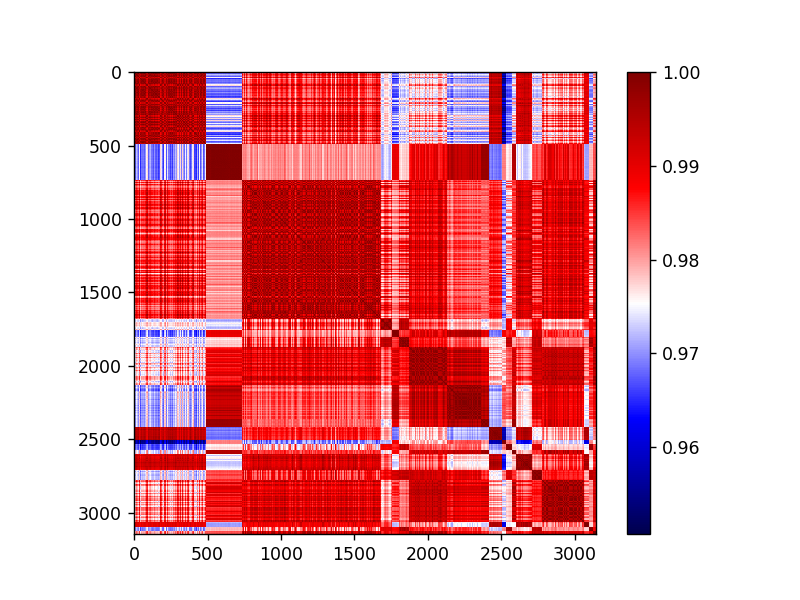

In [22]:
### Ordenar datos segun clusters asignados
lats_t = np.array([])
long_t = np.array([])
for i in range(max(etiqs)+1):
    latitude_list = np.array(lat)[np.where(np.array(etiqs)==i)]
    longitude_list = np.array(lon)[np.where(np.array(etiqs)==i)]    
    lats_t = np.concatenate((lats_t, latitude_list), axis=0)
    long_t = np.concatenate((long_t, longitude_list), axis=0)    

### Juntar latitud y longitud en un dataframe
fulldat = pd.DataFrame()
fulldat['lat'] = lats_t
fulldat['lon'] = long_t

## Obtener matriz de distancias
from scipy.spatial.distance import pdist, squareform
distm = pd.DataFrame(squareform(pdist(fulldat),'cityblock'))

### Cambiarla por matriz de similitudes
simil_m = 1 - distm.values 

### Pintar mapa de calor
import matplotlib.pyplot as plt
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='seismic')
    plt.colorbar()
    plt.show()
heatmap2d(simil_m)

Como vemos en el mapa de calor de la matriz de similitud, los cuadros de color más rojo oscuro que se forman quedan en la diagonal de esta matriz. Esto indica entonces que los datos que quedaban en un mismo cluster sí eran muy similares entre sí (los cuadros rojos oscuros de la diagonal representan los clusters). Por ende, validamos entonces que los clusters obtenidos por DBSCAN sí están siendo buenas agrupaciones para los datos.

### Conclusión

Se concluye entonces que es muy importante escoger bien los valores de los parámetros de radio de la bola y mínimo número de puntos para ser considerada densa para obtener buenos resultados, además de elegir bien la métrica de distancia. Además, se mostró que DBSCAN puede tener un desempeño mucho mejor que KMeans cuando los posibles clusters tienen formas y tamaños distintos y dependen de que tan pegados están los datos de cada grupo. Por último, se validaron los resultados de los clusters obtenidos por DBSCAN usando la matriz de similitud y se obtuvieron resultados satisfactorios.